# 01. Exploratory Data Analysis (EDA)

## Đề tài
Ứng dụng học máy trong phát hiện sớm rủi ro tín dụng của doanh nghiệp nhỏ và vừa (SMEs) tại TP. Hồ Chí Minh.

## Vai trò của EDA
- Hiểu cấu trúc và ý nghĩa kinh tế của dữ liệu
- Đánh giá chất lượng dữ liệu (missing, duplicate, outlier, inconsistency)
- Phân tích đơn biến/đa biến, kiểm tra drift theo thời gian
- Chốt quyết định tiền xử lý làm nền cho Labeling → Modeling → Scoring

In [54]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/NCKH"
DATA_RAW = f"{PROJECT_ROOT}/data/raw/final_research.csv"
DATA_PROCESSED = f"{PROJECT_ROOT}/data/processed"
SRC_DIR = f"{PROJECT_ROOT}/src"

import os, sys
os.makedirs(DATA_PROCESSED, exist_ok=True)
sys.path.append(SRC_DIR)

print("Setup done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup done


## Bước 1. Context Understanding – Ý nghĩa dữ liệu

Dữ liệu phản ánh báo cáo tài chính theo năm của các SMEs.  
Các nhóm biến chính bao gồm:

- **Quy mô doanh nghiệp**: total_assets, revenue  
  → Phản ánh size, ảnh hưởng mạnh đến rủi ro tín dụng

- **Đòn bẩy tài chính**: total_liabilities, equity, short_term_debt, long_term_debt  
  → Mức độ phụ thuộc nợ

- **Thanh khoản**: current_assets, current_liabilities, cash_and_equivalents  
  → Khả năng trả nợ ngắn hạn

- **Khả năng sinh lời**: gross_profit, net_income  
  → Sức khỏe tài chính cốt lõi

- **Chi phí tài chính & vận hành**: selling_expenses, admin_expenses, interest_expenses  
  → Áp lực chi phí

- **Dòng tiền**: cashflow_ops, cashflow_investing, cashflow_financing  
  → Năng lực tạo tiền và duy trì hoạt động

Việc hiểu rõ ý nghĩa kinh tế của các biến là nền tảng để xây dựng proxy default
và lựa chọn đặc trưng phù hợp cho mô hình học máy.
Lưu ý:
- Dữ liệu SMEs thường thiếu biến dòng tiền và có phân phối lệch phải (đuôi dài).
- EDA phải dẫn thẳng sang chiến lược: imputation + missing flags, winsorization, log-transform, time-based split.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from features import load_raw_data

df = load_raw_data(DATA_RAW)
df.shape

(453, 19)

In [56]:
df.sample(5)

,company_id,year,total_assets,equity,total_liabilities,current_assets,current_liabilities,cash_and_equivalents,short_term_debt,long_term_debt,revenue,gross_profit,net_income,selling_expenses,admin_expenses,interest_expenses,cashflow_ops,cashflow_investing,cashflow_financing
299,NOS,2024,3.615121e+11,-5.099548e+12,5.461060e+12,1.197449e+11,5.459597e+12,7.005186e+09,3.092591e+12,1.034757e+09,1.662792e+11,-1.087300e+11,-2.891862e+11,NaN,1.173696e+10,1.931651e+11,3.112142e+10,1.177287e+11,-5.019943e+10
396,VC6,2024,1.003989e+12,1.605278e+11,8.434610e+11,9.108806e+11,8.420551e+11,1.369627e+11,1.434780e+11,1.405891e+09,1.647088e+12,9.775091e+10,2.669654e+10,NaN,5.678866e+10,1.372189e+10,1.006369e+11,NaN,-9.348925e+10
350,SDP,2024,1.744883e+11,-6.489537e+10,2.393837e+11,1.570587e+11,2.393837e+11,1.799257e+09,1.756653e+10,NaN,3.073011e+10,1.830797e+09,-3.651401e+10,NaN,3.270044e+10,2.459231e+09,1.109218e+10,4.603349e+06,-9.538206e+09
302,NS2,2023,2.735125e+12,2.327648e+12,4.074762e+11,5.591483e+11,2.221297e+11,1.697061e+11,4.368744e+10,1.730275e+11,9.523409e+11,2.554574e+11,2.437985e+11,2.998037e+10,6.116173e+10,4.149546e+10,1.950016e+11,-1.338567e+09,-2.601980e+11
133,FTM,2023,7.823419e+11,-7.069517e+11,1.489294e+12,4.084591e+11,1.461067e+12,1.086976e+09,7.794892e+11,7.704527e+09,1.749820e+11,2.612270e+09,-3.224142e+11,1.632159e+09,1.389418e+11,1.106378e+11,-4.204509e+10,4.628601e+09,-3.078326e+09


## Bước 2. Kiểm tra cấu trúc dữ liệu

Thực hiện kiểm tra:
- Kích thước dữ liệu
- Kiểu dữ liệu các biến
- Thống kê mô tả cơ bản
- Phát hiện các biến dạng object/categorical (nếu có)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            453 non-null    object 
 1   year                  453 non-null    int64  
 2   total_assets          453 non-null    float64
 3   equity                453 non-null    float64
 4   total_liabilities     453 non-null    float64
 5   current_assets        453 non-null    float64
 6   current_liabilities   453 non-null    float64
 7   cash_and_equivalents  453 non-null    float64
 8   short_term_debt       360 non-null    float64
 9   long_term_debt        235 non-null    float64
 10  revenue               453 non-null    float64
 11  gross_profit          453 non-null    float64
 12  net_income            453 non-null    float64
 13  selling_expenses      342 non-null    float64
 14  admin_expenses        443 non-null    float64
 15  interest_expenses     4

In [28]:
df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_id,453,229,AAA,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,453.0,NaN,NaN,NaN,2023.496689,0.500542,2023.0,2023.0,2023.0,2024.0,2024.0
total_assets,453.0,NaN,NaN,NaN,1319779145139.10376,2257592609246.015137,8555744917.0,309942937388.0,645460497227.0,1326931516077.0,16695493770000.0
equity,453.0,NaN,NaN,NaN,578471762014.236206,1144981607996.172363,-5099547943578.0,150586395568.0,307100233034.0,618299638731.0,10687387469484.0
total_liabilities,453.0,NaN,NaN,NaN,741311548027.991211,1613269789907.317383,2635659832.0,96390959118.0,282569774093.0,714468096169.0,15156476047991.0
current_assets,453.0,NaN,NaN,NaN,748542388943.697632,1357228426268.267578,3765753843.0,148546031031.0,359500564189.0,803685130922.0,13734790530380.0
current_liabilities,453.0,NaN,NaN,NaN,605849376132.2229,1387658940384.226562,2635659832.0,75598394850.0,211665837703.0,601584763565.0,14304209578000.0
cash_and_equivalents,453.0,NaN,NaN,NaN,97096791363.476822,218690930917.380615,9110310.0,6211723748.0,25022059478.0,94467547790.0,2435058282483.0
short_term_debt,360.0,NaN,NaN,NaN,369847417901.68335,862084039651.671387,80000000.0,35223642998.75,107834185742.0,351129068147.0,9611827260000.0
long_term_debt,235.0,NaN,NaN,NaN,178309034771.919159,398614966787.536926,80000000.0,7388395000.0,30675378757.0,154371001911.5,2713930000000.0


In [29]:
df.dtypes.value_counts()

,count
float64,17
object,1
int64,1


### Nhận xét
- Phần lớn biến là **định lượng liên tục**
- Dữ liệu **không chứa biến phân loại (categorical)** như ngành nghề
→ Phân tích tập trung hoàn toàn vào các biến tài chính định lượng

## Bước 3. Chất lượng dữ liệu
- Missing values: tỷ lệ + heatmap
- Duplicates: toàn phần + theo khóa (company_id, year)
- Outliers: boxplot + IQR outlier rate
- Inconsistency: kiểm tra miền giá trị hợp lý (theo logic tài chính)

In [57]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.head(15)

,0
cashflow_investing,58.278146
long_term_debt,48.123620
selling_expenses,24.503311
short_term_debt,20.529801
interest_expenses,7.284768
cashflow_financing,6.181015
admin_expenses,2.207506
total_assets,0.000000
year,0.000000
company_id,0.000000


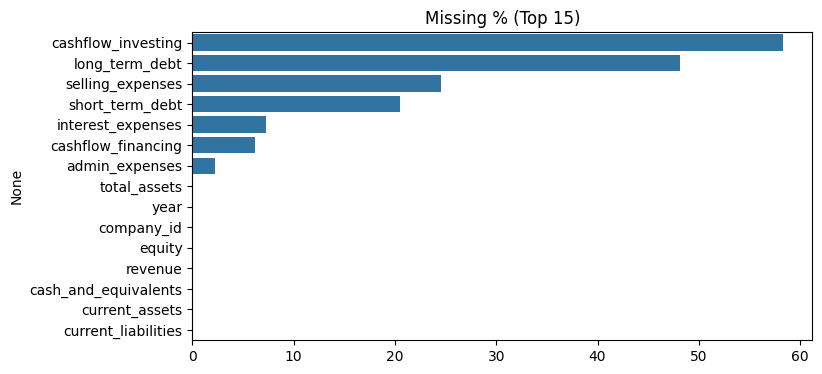

In [58]:
plt.figure(figsize=(8,4))
sns.barplot(x=missing_pct.head(15).values, y=missing_pct.head(15).index)
plt.title("Missing % (Top 15)")
plt.show()

- Missing tập trung ở các biến dòng tiền và nợ dài hạn
- Đây là đặc trưng phổ biến của SMEs
- Quyết định: **không loại bỏ quan sát**, xử lý bằng imputation kết hợp missing indicator ở bước feature engineering

In [59]:
df.duplicated().sum(), df.duplicated(subset=["company_id","year"]).sum()

(np.int64(0), np.int64(0))

## Ngoại lai (Outliers)

Dữ liệu tài chính thường có phân phối lệch phải và xuất hiện giá trị rất lớn.
Ngoại lai trong trường hợp này **không nhất thiết là lỗi**, nhưng cần được kiểm soát
để tránh làm méo mô hình.

In [60]:
num_cols = [
    "total_assets","revenue","total_liabilities",
    "equity","net_income","cashflow_ops","interest_expenses"
]

df[num_cols].describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
total_assets,453.0,1.319779e+12,2.257593e+12,8.555745e+09,3.436365e+10,9.054447e+10,6.454605e+11,4.002974e+12,1.363867e+13,1.669549e+13
revenue,453.0,1.096171e+12,2.107601e+12,1.754080e+08,1.052597e+09,9.783888e+09,4.126467e+11,4.460818e+12,8.957878e+12,2.060902e+13
total_liabilities,453.0,7.413115e+11,1.613270e+12,2.635660e+09,3.545349e+09,9.894830e+09,2.825698e+11,2.643795e+12,7.587496e+12,1.515648e+13
equity,453.0,5.784718e+11,1.144982e+12,-5.099548e+12,-7.569928e+11,-5.619738e+10,3.071002e+11,1.995825e+12,6.094624e+12,1.068739e+13
net_income,453.0,2.628503e+10,1.843338e+11,-1.281879e+12,-9.509042e+11,-1.594516e+11,1.533063e+10,2.672237e+11,4.717604e+11,9.629625e+11
cashflow_ops,453.0,5.588244e+10,2.277273e+11,-9.013464e+11,-5.387795e+11,-1.367066e+11,1.313166e+10,3.146736e+11,9.497625e+11,2.615216e+12
interest_expenses,420.0,3.328219e+10,6.704361e+10,-2.526991e+10,-6.691513e+08,3.319347e+07,9.510990e+09,1.548147e+11,3.396292e+11,5.594573e+11


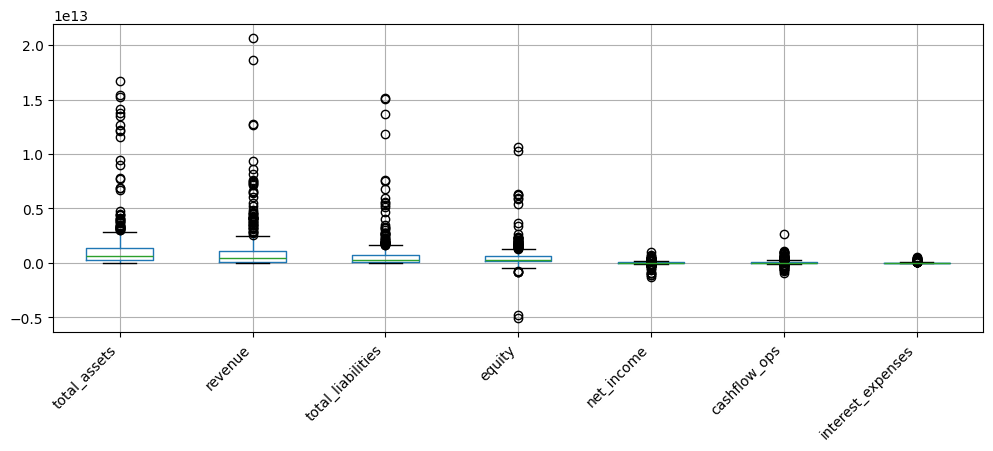

In [61]:
plt.figure(figsize=(12,4))
df[num_cols].boxplot()
plt.xticks(rotation=45, ha="right")
plt.show()

In [62]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_rate = (((df[num_cols] < (Q1-1.5*IQR)) | (df[num_cols] > (Q3+1.5*IQR))).mean()).sort_values(ascending=False)
outlier_rate

,0
net_income,0.185430
cashflow_ops,0.130243
equity,0.125828
interest_expenses,0.112583
revenue,0.110375
total_liabilities,0.105960
total_assets,0.094923


## Inconsistency theo logic tài chính

- Giá trị âm **có thể hợp lý**: net_income, cashflow_ops  
- Giá trị âm **không hợp lý**: total_assets, current_assets, revenue

Do đó cần phân biệt khi kiểm tra tính nhất quán.

In [63]:
invalid = {
    "total_assets < 0": int((df["total_assets"] < 0).sum()),
    "current_assets < 0": int((df["current_assets"] < 0).sum()),
    "revenue < 0": int((df["revenue"] < 0).sum()),
}
valid_neg = {
    "net_income < 0 rate": float((df["net_income"] < 0).mean()),
    "cashflow_ops < 0 rate": float((df["cashflow_ops"] < 0).mean())
}
pd.Series({**invalid, **valid_neg})

,0
total_assets < 0,0.000000
current_assets < 0,0.000000
revenue < 0,0.000000
net_income < 0 rate,0.238411
cashflow_ops < 0 rate,0.346578


## Bước 4. Phân tích đơn biến (Univariate Analysis)

- Stats: mean, median, std, min, max, skew, kurtosis
- Plots: histogram + KDE, boxplot

Mục tiêu:
- Hiểu phân phối
- Đánh giá độ lệch, độ nhọn
- Xác định biến cần log-transform hoặc winsorization

In [64]:
df[num_cols].agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
total_assets,1.319779e+12,6.454605e+11,2.257593e+12,8.555745e+09,1.669549e+13,4.286457,20.801000
revenue,1.096171e+12,4.126467e+11,2.107601e+12,1.754080e+08,2.060902e+13,4.740274,31.171693
total_liabilities,7.413115e+11,2.825698e+11,1.613270e+12,2.635660e+09,1.515648e+13,5.856865,42.444857
equity,5.784718e+11,3.071002e+11,1.144982e+12,-5.099548e+12,1.068739e+13,3.997317,32.087296
net_income,2.628503e+10,1.533063e+10,1.843338e+11,-1.281879e+12,9.629625e+11,-2.252710,18.189041
cashflow_ops,5.588244e+10,1.313166e+10,2.277273e+11,-9.013464e+11,2.615216e+12,3.956911,39.545621
interest_expenses,3.328219e+10,9.510990e+09,6.704361e+10,-2.526991e+10,5.594573e+11,4.065386,20.727750


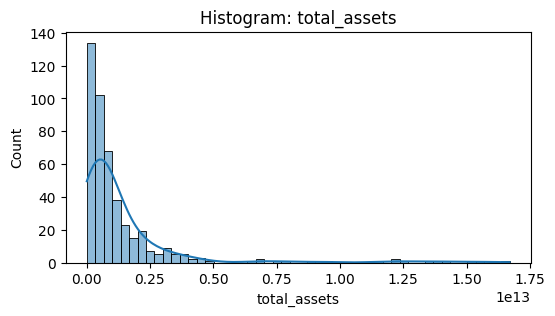

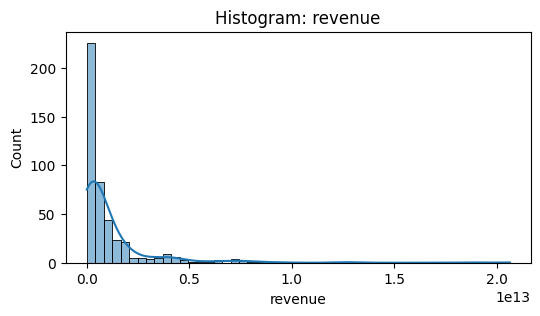

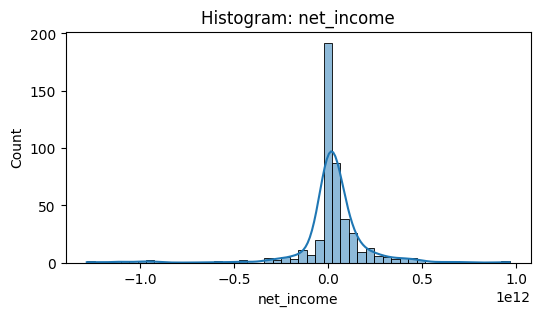

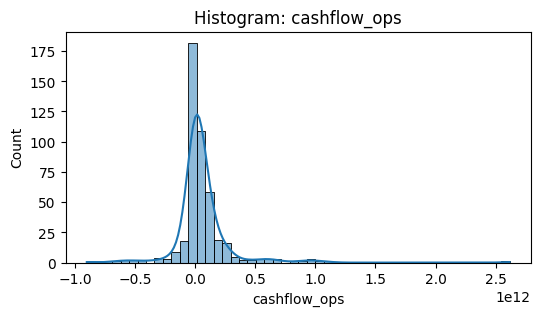

In [65]:
for c in ["total_assets","revenue","net_income","cashflow_ops"]:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c], bins=50, kde=True)
    plt.title(f"Histogram: {c}")
    plt.show()

## Bước 5. Phân tích đa biến
- Correlation (Spearman ưu tiên do lệch phân phối)
- Scatter để nhìn quan hệ
- Nhận diện đa cộng tuyến

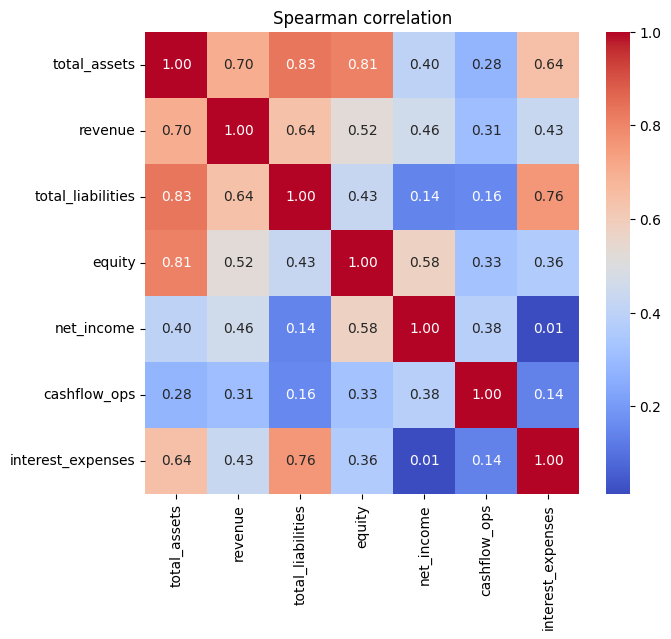

In [66]:
corr = df[num_cols].corr(method="spearman")
plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman correlation")
plt.show()

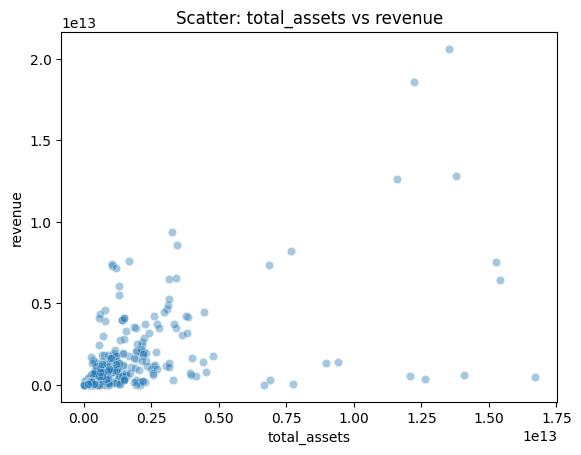

In [67]:
sns.scatterplot(x="total_assets", y="revenue", data=df, alpha=0.4)
plt.title("Scatter: total_assets vs revenue")
plt.show()

## Bước 6. Phân tích theo thời gian (drift)
Kiểm tra sự thay đổi phân phối theo year để:
- củng cố quyết định time-based split
- giảm rủi ro leakage nếu random split

In [68]:
year_summary = df.groupby("year").agg(
    n_company=("company_id","nunique"),
    assets_median=("total_assets","median"),
    assets_q25=("total_assets", lambda x: x.quantile(0.25)),
    assets_q75=("total_assets", lambda x: x.quantile(0.75)),
    revenue_median=("revenue","median")
).reset_index()

year_summary

,year,n_company,assets_median,assets_q25,assets_q75,revenue_median
0,2023,228,6.411427e+11,3.079986e+11,1.324787e+12,4.167127e+11
1,2024,225,6.650331e+11,3.147306e+11,1.329205e+12,4.116241e+11


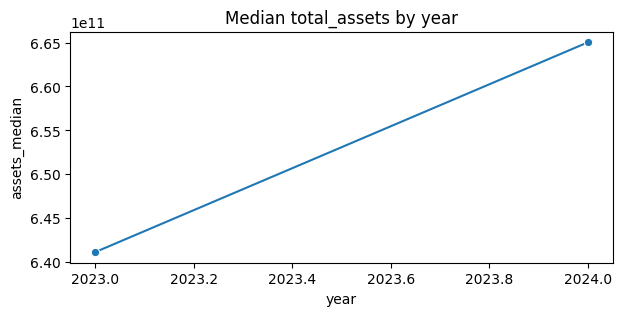

In [69]:
plt.figure(figsize=(7,3))
sns.lineplot(data=year_summary, x="year", y="assets_median", marker="o")
plt.title("Median total_assets by year")
plt.show()

## Bước 7. EDA Summary & Decisions (chốt cho pipeline)

Quyết định:
1. Không drop bừa dữ liệu SMEs → dùng imputation + missing flags
2. Outlier phổ biến → winsorize các ratio (q01–q99)
3. Quy mô rất lớn → log-transform (log1p total_assets)
4. Dữ liệu theo year → time-based split (anti-leakage)

EDA này trực tiếp dẫn tới:
- Proxy default dựa trên stress tài chính (Notebook 02)
- ML dự đoán PD (Notebook 03)
- Calibration và PD → Score 1–10 (Notebook 04)

In [70]:
eda_missing = missing_pct.reset_index()
eda_missing.columns = ["variable","missing_percent"]

eda_outlier = outlier_rate.reset_index()
eda_outlier.columns = ["variable","iqr_outlier_rate"]

eda_report = eda_missing.merge(eda_outlier, on="variable", how="left")
eda_report.to_csv(f"{DATA_PROCESSED}/eda_report.csv", index=False)

print("Saved:", f"{DATA_PROCESSED}/eda_report.csv")
eda_report.head(10)

Saved: /content/drive/MyDrive/NCKH/data/processed/eda_report.csv


,variable,missing_percent,iqr_outlier_rate
0,cashflow_investing,58.278146,NaN
1,long_term_debt,48.123620,NaN
2,selling_expenses,24.503311,NaN
3,short_term_debt,20.529801,NaN
4,interest_expenses,7.284768,0.112583
5,cashflow_financing,6.181015,NaN
6,admin_expenses,2.207506,NaN
7,total_assets,0.000000,0.094923
8,year,0.000000,NaN
9,company_id,0.000000,NaN
